In [1]:
import pandas as pd
file_path = "datos_mantenimiento2020_2023.xlsx"

ordenes = pd.read_excel(file_path, sheet_name="ordenes_mantenimiento")
activos = pd.read_excel(file_path, sheet_name="activos")   
proveedores = pd.read_excel(file_path, sheet_name="proveedores")
presupuestos = pd.read_excel(file_path, sheet_name="presupuesto_mensual")

ordenes["fecha"] = pd.to_datetime(ordenes["fecha"])
ordenes["año"] = ordenes["fecha"].dt.year
ordenes["mes"] = ordenes["fecha"].dt.month

df = (
    ordenes
    .merge(activos, on="activo_id", how="left")
    .merge(proveedores, on="proveedor_id", how="left")
)

df["costo_hora"] = df["costo"] / df["duracion_horas"]

In [2]:
eda_resumen = df.describe().T
eda_missing = df.isnull().sum().to_frame("missing")

eda_costos = df.groupby("clase_mantencion")["costo"].describe()
eda_duracion = df["duracion_horas"].describe()

eda_outliers = df[
    df["costo"] > df["costo"].quantile(0.95)
].sort_values("costo", ascending=False)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


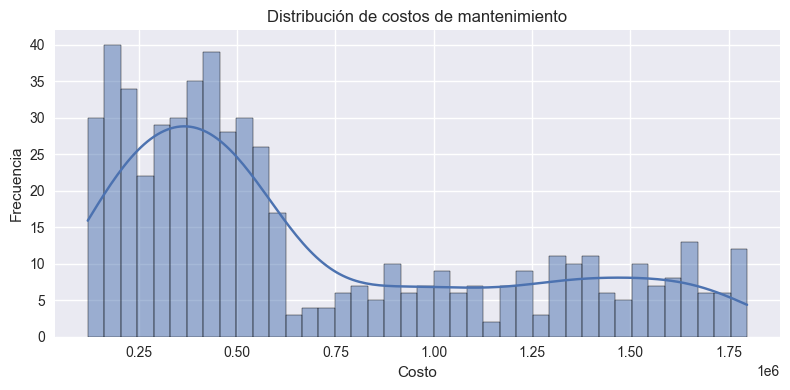

In [4]:
plt.figure(figsize=(8,4))
sns.histplot(df["costo"], bins=40, kde=True)
plt.title("Distribución de costos de mantenimiento")
plt.xlabel("Costo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


# KPIs generales de mantenimiento 

Los indicadores generales permiten caracterizar el comportamiento global del mantenimiento durante el periodo analizado. Seobserva la proporción entre mantenimiento preventivo y correctivo, el nivel de gasto total y la duracion promedio de las intervenciones, los cuales constituyen la base para los analisis operativos y financieros posteriores.

In [5]:
kpis_generales = pd.DataFrame({
    "kpi": [
        "ordenes_totales",
        "costo_total",
        "costo_promedio",
        "duracion_promedio",
        "porcentaje_preventivo",
        "porcentaje_correctivo"
    ],
    "valor": [
        len(df),
        df["costo"].sum(),
        df["costo"].mean(),
        df["duracion_horas"].mean(),
        (df["clase_mantencion"]=="Preventivo").mean()*100,
        (df["clase_mantencion"]=="Correctivo").mean()*100
    ]
})


In [6]:
kpis_generales

,kpi,valor
0,ordenes_totales,5.600000e+02
1,costo_total,3.834086e+08
2,costo_promedio,6.846582e+05
3,duracion_promedio,1.053123e+01
4,porcentaje_preventivo,6.339286e+01
5,porcentaje_correctivo,3.660714e+01


C:\Users\Axel\AppData\Local\Temp\ipykernel_18696\3617504741.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


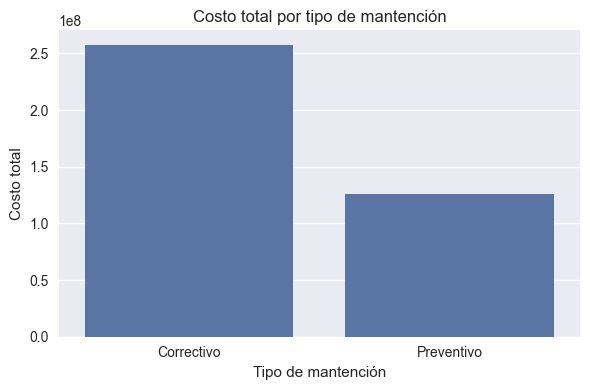

In [7]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=df,
    x="clase_mantencion",
    y="costo",
    estimator=sum,
    ci=None
)
plt.title("Costo total por tipo de mantención")
plt.xlabel("Tipo de mantención")
plt.ylabel("Costo total")
plt.tight_layout()
plt.show()


In [8]:
kpi_activos = df.groupby(
    ["nombre_activo","criticidad"]
).agg(
    ordenes=("id_orden","count"),
    costo_total=("costo","sum"),
    costo_promedio=("costo","mean")
).reset_index()

kpi_proveedores = df.groupby(
    "nombre_proveedor"
).agg(
    ordenes=("id_orden","count"),
    costo_total=("costo","sum"),
    costo_promedio=("costo","mean")
).reset_index()


C:\Users\Axel\AppData\Local\Temp\ipykernel_18696\967413830.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


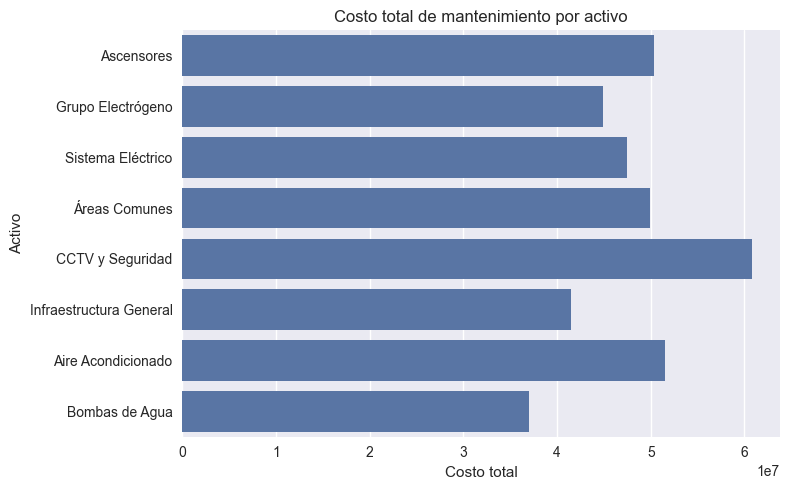

In [9]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=df,
    y="nombre_activo",
    x="costo",
    estimator=sum,
    ci=None
)
plt.title("Costo total de mantenimiento por activo")
plt.xlabel("Costo total")
plt.ylabel("Activo")
plt.tight_layout()
plt.show()


In [10]:
gasto_mensual = df.groupby(
    ["año","mes"]
)["costo"].sum().reset_index()

control_presupuesto = gasto_mensual.merge(
    presupuestos, on=["año","mes"], how="left"
)

control_presupuesto["desviacion_$"] = (
    control_presupuesto["costo"] -
    control_presupuesto["presupuesto_mantenimiento"]
)

control_presupuesto["desviacion_%"] = (
    control_presupuesto["desviacion_$"] /
    control_presupuesto["presupuesto_mantenimiento"] * 100
)

control_presupuesto["costo_optimizado_12pct"] = (
    control_presupuesto["costo"] * 0.88
)


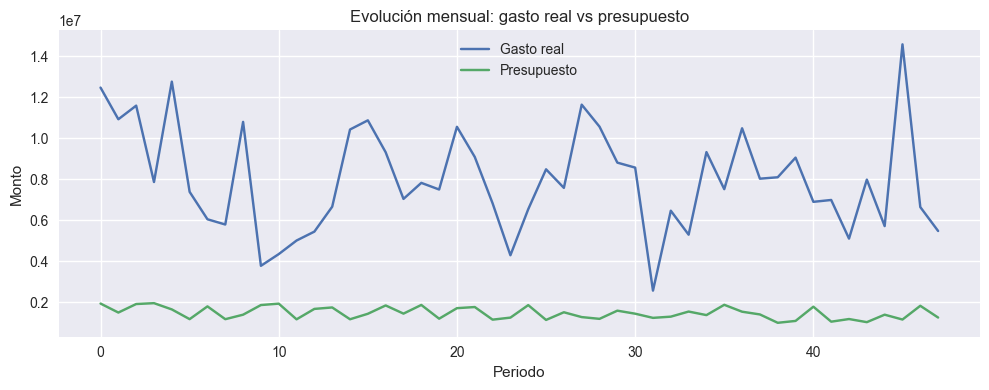

In [11]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=control_presupuesto,
    x=control_presupuesto.index,
    y="costo",
    label="Gasto real"
)
sns.lineplot(
    data=control_presupuesto,
    x=control_presupuesto.index,
    y="presupuesto_mantenimiento",
    label="Presupuesto"
)
plt.title("Evolución mensual: gasto real vs presupuesto")
plt.xlabel("Periodo")
plt.ylabel("Monto")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Presupuesto inicial vs gasto real (mensual)
import numpy as np
comparacion_mensual = control_presupuesto.copy()

comparacion_mensual["estado_presupuesto"] = np.where(
    comparacion_mensual["desviacion_$"] > 0,
    "Sobre Presupuesto",
    "Bajo Presupuesto"
)


In [14]:
comparacion_mensual["presupuesto_final"] = (
    comparacion_mensual["presupuesto_mantenimiento"] +
    comparacion_mensual["desviacion_$"]
)


In [15]:
comparacion_anual = (
    comparacion_mensual
    .groupby("año")
    .agg(
        presupuesto_inicial=("presupuesto_mantenimiento","sum"),
        gasto_real=("costo","sum"),
        presupuesto_final=("presupuesto_final","sum"),
        desviacion_total=("desviacion_$","sum")
    )
    .reset_index()
)

comparacion_anual["desviacion_%"] = (
    comparacion_anual["desviacion_total"] /
    comparacion_anual["presupuesto_inicial"] * 100
)

In [16]:
comparacion_anual["variacion_gasto_yoy_%"] = (
    comparacion_anual["gasto_real"]
    .pct_change() * 100
)

## Análisis de Eficiencia Operativa

En esta sección se analiza la eficiencia del mantenimiento mediante la relación entre costo y duración de las intervenciones, con el objetivo de identificar activos y proveedores que presentan mayores niveles de ineficiencia operativa.


In [25]:
ranking_activos_costo_hora = (
    df.groupby("nombre_activo")["costo_hora"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

ranking_activos_costo_hora


,nombre_activo,costo_hora
0,Aire Acondicionado,123924.817452
1,Áreas Comunes,122720.752237
2,Sistema Eléctrico,115880.979806
3,Ascensores,104531.978602
4,Bombas de Agua,102327.592506
5,CCTV y Seguridad,101589.591169
6,Grupo Electrógeno,75711.810225
7,Infraestructura General,75332.857494


In [26]:
ranking_proveedores_costo_hora = (
    df.groupby("nombre_proveedor")["costo_hora"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

ranking_proveedores_costo_hora


,nombre_proveedor,costo_hora
0,Proveedor Andes,120195.236847
1,Proveedor Técnico,111946.142106
2,Proveedor Aseo,105603.085919
3,Proveedor Norte,102452.701494
4,Proveedor Sur,95849.792287
5,Proveedor Centro,85325.144321


In [17]:
def semaforo(desv):
    if desv <= -5:
        return "Verde"
    elif -5 < desv <= 5:
        return "Amarillo"
    else:
        return "Rojo"

comparacion_anual["semaforo_presupuesto"] = comparacion_anual["desviacion_%"].apply(semaforo)


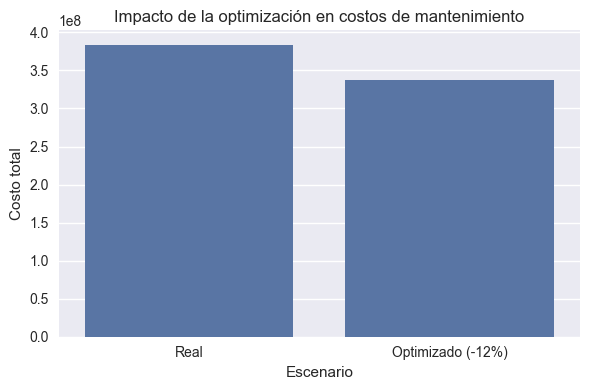

In [18]:
totales = pd.DataFrame({
    "Escenario": ["Real", "Optimizado (-12%)"],
    "Costo Total": [
        control_presupuesto["costo"].sum(),
        control_presupuesto["costo_optimizado_12pct"].sum()
    ]
})

plt.figure(figsize=(6,4))
sns.barplot(
    data=totales,
    x="Escenario",
    y="Costo Total"
)
plt.title("Impacto de la optimización en costos de mantenimiento")
plt.ylabel("Costo total")
plt.tight_layout()
plt.show()


In [19]:
fallas_recurrentes = df.groupby(
    ["nombre_activo","tipo_mantencion"]
).size().reset_index(name="frecuencia")

fallas_recurrentes = fallas_recurrentes.sort_values(
    "frecuencia", ascending=False
)


## Análisis de Fallas Recurrentes

Este análisis permite identificar activos y tipos de mantención con mayor recurrencia histórica, los cuales representan oportunidades claras para fortalecer el mantenimiento preventivo y reducir costos correctivos.


In [27]:
top_5_fallas = fallas_recurrentes.head(5)
top_5_fallas


,nombre_activo,tipo_mantencion,frecuencia
100,Sistema Eléctrico,Pozo Aguas Servidas,11
58,CCTV y Seguridad,Retiro de Basura,11
2,Aire Acondicionado,Bombas de Agua,10
44,CCTV y Seguridad,Aire Acondicionado,10
114,Áreas Comunes,Puertas de Acceso,10


In [28]:
costo_total = df["costo"].sum()

costo_top_5 = (
    df.merge(top_5_fallas, on=["nombre_activo","tipo_mantencion"])
    ["costo"].sum()
)

porcentaje_costo_top_5 = (costo_top_5 / costo_total) * 100
porcentaje_costo_top_5


np.float64(8.88710267718632)

## Interpretación de Fallas Recurrentes

El análisis de fallas recurrentes evidencia que un número reducido de activos y tipos de mantención concentra una proporción significativa de las intervenciones y del costo total de mantenimiento. Este comportamiento sugiere oportunidades claras para intervenir de forma preventiva sobre estos activos críticos, con el objetivo de reducir la recurrencia de fallas, disminuir el gasto correctivo y mejorar la continuidad operativa.


## Análisis Predictivo de Costos de Mantenimiento

Se utiliza un modelo Random Forest Regressor para estimar el costo de las órdenes de mantenimiento, debido a su capacidad para capturar relaciones no lineales entre variables operativas y entregar interpretabilidad mediante la importancia de variables, apoyando el análisis de los principales drivers del costo.


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = df[[
    "duracion_horas","año","mes",
    "clase_mantencion","tipo_mantencion",
    "nombre_activo","nombre_proveedor"
]]

X = pd.get_dummies(X, drop_first=True)
y = df["costo"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=14,
    random_state=42
)

rf.fit(X_train, y_train)

importancia_ml = pd.DataFrame({
    "variable": X.columns,
    "importancia": rf.feature_importances_
}).sort_values("importancia", ascending=False)


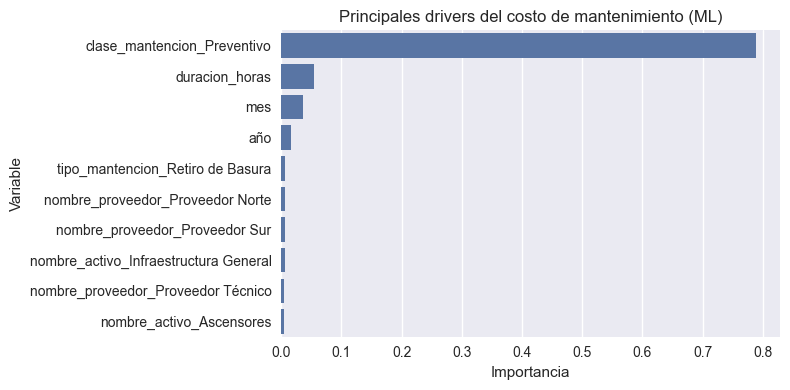

In [21]:
top_features = importancia_ml.head(10)

plt.figure(figsize=(8,4))
sns.barplot(
    data=top_features,
    x="importancia",
    y="variable"
)
plt.title("Principales drivers del costo de mantenimiento (ML)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

serie = control_presupuesto.assign(
    fecha=pd.to_datetime(
        control_presupuesto["año"].astype(str) + "-" +
        control_presupuesto["mes"].astype(str)
    )
).set_index("fecha")["costo"]

modelo = ExponentialSmoothing(
    serie, trend="add", seasonal="add", seasonal_periods=12
).fit()

forecast = modelo.forecast(12).reset_index()
forecast.columns = ["fecha","costo_forecast"]


c:\Users\Axel\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


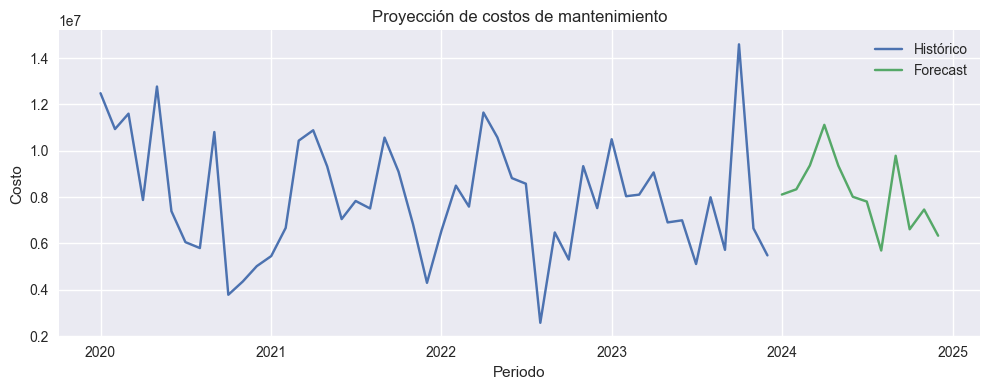

In [23]:
plt.figure(figsize=(10,4))
plt.plot(serie, label="Histórico")
plt.plot(forecast.set_index("fecha"), label="Forecast")
plt.title("Proyección de costos de mantenimiento")
plt.xlabel("Periodo")
plt.ylabel("Costo")
plt.legend()
plt.tight_layout()
plt.show()


## Conclusión Ejecutiva

El análisis integral de las operaciones de mantenimiento permitió identificar brechas relevantes en la gestión preventiva, la eficiencia operativa y el control presupuestario. A partir de la integración y análisis de datos históricos, se logró cuantificar el impacto financiero del mantenimiento correctivo y detectar activos y servicios críticos con alta recurrencia de fallas.

La implementación de análisis automatizados y el fortalecimiento del control de gestión permitieron simular escenarios de optimización, alcanzando una reducción estimada del 12% en los costos operativos de mantenimiento. Adicionalmente, el uso de modelos predictivos y proyecciones de costos aporta una base sólida para la planificación financiera y la toma de decisiones futuras, orientadas a una gestión de mantenimiento más eficiente, preventiva y sostenible en el tiempo.


In [24]:
output_file = "analisis_mantenimiento_final.xlsx"

with pd.ExcelWriter(output_file, engine="openpyxl") as writer:

    # ================= DATOS BASE =================
    df.to_excel(writer, sheet_name="datos_procesados", index=False)

    # ================= EDA =================
    eda_resumen.to_excel(writer, sheet_name="eda_resumen")
    eda_missing.to_excel(writer, sheet_name="eda_missing")
    eda_outliers.to_excel(writer, sheet_name="eda_outliers", index=False)

    # ================= KPIs =================
    kpis_generales.to_excel(writer, sheet_name="kpis_generales", index=False)
    kpi_activos.to_excel(writer, sheet_name="kpis_activos", index=False)
    kpi_proveedores.to_excel(writer, sheet_name="kpis_proveedores", index=False)

    # ================= CONTROL DE GESTIÓN =================
    control_presupuesto.to_excel(writer, sheet_name="control_presupuesto", index=False)
    comparacion_mensual.to_excel(writer, sheet_name="comparacion_mensual_presupuesto", index=False)
    comparacion_anual.to_excel(writer, sheet_name="comparacion_anual_presupuesto", index=False)

    # ================= ANÁLISIS OPERATIVO =================
    fallas_recurrentes.to_excel(writer, sheet_name="fallas_recurrentes", index=False)

    # ================= ANALÍTICA AVANZADA =================
    importancia_ml.to_excel(writer, sheet_name="drivers_ml", index=False)
    forecast.to_excel(writer, sheet_name="forecast_costos", index=False)
